In [1]:
import neuron
from neuron import h
from neuron.units import ms, mV
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import json
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

h.load_file('stdrun.hoc')
neuron.load_mechanisms('mechanisms')
h.load_file('templates/templates.hoc') # reads in template

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.celsius = 36.0

### Set parameters for different connection types

#### Basic settings

In [2]:
settings = {
    'post_cell': 'CP_Cell',
    'sec_id': 1,
    'sec_x': 0.5,
    'syn_type': 'AMPA_NMDA_STP',
    'vclamp': True,
    'vclamp_amp': -60.,
    'rise_interval': (0.2, 0.8),
    'tstart': 500.,
    'tdur': 1100.,
    'threshold': 0., # netcon
    'delay': 1.6, # netcon
    'weight': 1., # netcon
}
syn_param_exc = {
    'initW': 1.0,
    'tau_r_AMPA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_AMPA': 1.7, # (ms) IMPORTANT: tau_r < tau_d
    'Use': 1., # (1) Utilization of synaptic efficacy
    'Dep': 100., # (ms) Relaxation time constant from depression
    'Fac': 10., # (ms) Relaxation time constant from facilitation
}
syn_param_inh = {
    'initW': 1.0,
    'tau_r_GABAA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_GABAA': 8., # (ms) IMPORTANT: tau_r < tau_d
    'Use': 1., # (1) Utilization of synaptic efficacy
    'Dep': 100., # (ms) Relaxation time constant from depression
    'Fac': 10., # (ms) Relaxation time constant from facilitation
}

#### Settings for individual conection types

In [3]:
Connection = 'LTS2LTS'

if Connection == 'CP2CP':
    spec_settings = {
        'post_cell': 'CP_Cell',
        'sec_x': 0.4,
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 3.6,
        'tau_d_AMPA': 5.2,
        'Use': 0.37,
        'Dep': 31.7,
        'Fac': 519.,
    }
elif Connection == 'CP2CS':
    spec_settings = {
        'post_cell': 'CS_Cell',
        'sec_x': 0.4,
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 2.6,
        'tau_d_AMPA': 5.2,
        'Use': 0.37,
        'Dep': 31.7,
        'Fac': 519.,
    }
elif Connection == 'CS2CS':
    spec_settings = {
        'post_cell': 'CS_Cell',
        'sec_x': 0.4,
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 1.5,
        'tau_d_AMPA': 5.2,
        'Use': 0.41,
        'Dep': 532.,
        'Fac': 65.
    }
elif Connection == 'CS2CP':
    spec_settings = {
        'post_cell': 'CP_Cell',
        'sec_x': 0.4,
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 1.6,
        'tau_d_AMPA': 5.2,
        'Use': 0.41,
        'Dep': 532.,
        'Fac': 65.
    }
elif Connection == 'CP2FSI':
    spec_settings = {
        'post_cell': 'FSI_Cell',
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 15.,
        'tau_r_AMPA': 0.4,
        'tau_d_AMPA': 2.9,
        'Use': 0.035,
        'Dep': 500.,
        'Fac': 0.
    }
elif Connection == 'CS2FSI':
    spec_settings = {
        'post_cell': 'FSI_Cell',
        'vclamp': False,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 3.3,
        'tau_r_AMPA': 0.45,
        'tau_d_AMPA': 3.8,
        'Use': 0.18,
        'Dep': 600.,
        'Fac': 0.
    }
elif Connection == 'CP2LTS':
    spec_settings = {
        'post_cell': 'LTS_Cell',
        'vclamp': False,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 1.8,
        'tau_r_AMPA': 0.4,
        'tau_d_AMPA': 3.9,
        'Use': 0.05,
        'Dep': 0.,
        'Fac': 200.
    }
elif Connection == 'CS2LTS':
    spec_settings = {
        'post_cell': 'LTS_Cell',
        'vclamp': False,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_exc.copy()
    spec_syn_param = {
        'initW': 0.76,
        'tau_r_AMPA': 0.45,
        'tau_d_AMPA': 7.5,
        'Use': 0.13,
        'Dep': 0.,
        'Fac': 200.
    }
elif Connection == 'FSI2CP':
    spec_settings = {
        'post_cell': 'CP_Cell',
        'sec_id': 0,
        'syn_type': 'GABA_AB_STP',
        'vclamp': False,
        'vclamp_amp': -60.,
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 1.5,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'e_GABAA': -90.,
        'Use': 0.3,
        'Dep': 400.,
        'Fac': 0.
    }
elif Connection == 'FSI2CS':
    spec_settings = {
        'post_cell': 'CS_Cell',
        'sec_id': 0,
        'syn_type': 'GABA_AB_STP',
        'vclamp': False,
        'vclamp_amp': -60.,
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 3.0,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'e_GABAA': -90.,
        'Use': 0.3,
        'Dep': 400.,
        'Fac': 0.
    }
elif Connection == 'LTS2CP':
    spec_settings = {
        'post_cell': 'CP_Cell',
        'sec_id': 2,
        'sec_x': 0.8,
        'syn_type': 'GABA_AB_STP',
        'vclamp': False,
        'vclamp_amp': -60.,
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 1.0,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'e_GABAA': -90.,
        'Use': 0.3,
        'Dep': 25.,
        'Fac': 100.
    }
elif Connection == 'LTS2CS':
    spec_settings = {
        'post_cell': 'CS_Cell',
        'sec_id': 2,
        'sec_x': 0.8,
        'syn_type': 'GABA_AB_STP',
        'vclamp': False,
        'vclamp_amp': -60.,
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 1.4,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'e_GABAA': -90.,
        'Use': 0.3,
        'Dep': 25.,
        'Fac': 100.
    }
elif Connection == 'FSI2FSI':
    spec_settings = {
        'post_cell': 'FSI_Cell',
        'sec_id': 0,
        'syn_type': 'GABA_AB_STP',
        'vclamp_amp': -50.,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 3.0,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'Use': 0.3,
        'Dep': 400.,
        'Fac': 0.
    }
elif Connection == 'FSI2LTS':
    spec_settings = {
        'post_cell': 'LTS_Cell',
        'sec_id': 0,
        'syn_type': 'GABA_AB_STP',
        'vclamp_amp': -60.,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 3.0,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'Use': 0.3,
        'Dep': 400.,
        'Fac': 0.
    }
elif Connection == 'LTS2FSI':
    spec_settings = {
        'post_cell': 'FSI_Cell',
        'sec_id': 0,
        'syn_type': 'GABA_AB_STP',
        'vclamp_amp': -50.,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 3.0,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'Use': 0.3,
        'Dep': 25.,
        'Fac': 100.
    }
elif Connection == 'LTS2LTS':
    spec_settings = {
        'post_cell': 'LTS_Cell',
        'sec_id': 0,
        'syn_type': 'GABA_AB_STP',
        'vclamp_amp': -60.,
        'rise_interval': (0.1, 0.9),
    }
    syn_param = syn_param_inh.copy()
    spec_syn_param = {
        'initW': 3.0,
        'tau_r_GABAA': 0.2,
        'tau_d_GABAA': 8.,
        'Use': 0.3,
        'Dep': 25.,
        'Fac': 100.
    }

settings.update(spec_settings)
syn_param.update(spec_syn_param)

### Set up model for simulation

In [4]:
tstart = settings['tstart']
tdur = settings['tdur']
h.tstop = tstop = tstart + tdur # how long to run the simulation in ms

cell = getattr(h, settings['post_cell'])()
syn = getattr(h,settings['syn_type'])(list(cell.all)[settings['sec_id']](settings['sec_x']))
nstim = h.NetStim()
nstim.start = tstart
nstim.noise = 0
nc = h.NetCon(nstim, syn, settings['threshold'], settings['delay'], settings['weight'])
vcl = h.VClamp(cell.soma[0](0.5))
vcldur = [[0, 0, 0],[tstart, tstop, 1e9]]
vcl_on = True
for i in range(3):
    vcl.amp[i] = settings['vclamp_amp']

def switch_vclamp(on=True):
    global vcl_on
    vcl_on = on
    on = int(on)
    for i in range(3):
        vcl.dur[i] = vcldur[on][i]

switch_vclamp(settings['vclamp'])

t = h.Vector() # Vectors are used to record data in the simulation
tspk = h.Vector() # synapse event times
soma_v = h.Vector()
ivcl = h.Vector()
isyn = h.Vector()
Use_rec = h.Vector()
Pr = h.Vector()
t.record(h._ref_t) # derefences and records data
nc.record(tspk)
soma_v.record(cell.soma[0](0.5)._ref_v)
ivcl.record(vcl._ref_i)
isyn.record(syn._ref_i)
Pr.record(syn._ref_record_Pr)
Use_rec.record(syn._ref_record_use)

Vector[5]

### Single synaptic event and evaluate properties

#### Functions for estimating synaptic properties

In [5]:
def find_first(x):
    x = np.asarray(x)
    idx = np.nonzero(x)[0]
    if idx.size:
        return idx[0]
    else:
        return None

def get_syn_prop(isyn, tspk, rise_interval=(0.2, 0.8), dt=h.dt):
    isyn = np.asarray(isyn)
    tspk = np.asarray(tspk)
    if tspk.size:
        tspk = tspk[0]
    ispk = int(np.floor(tspk / dt))
    baseline = isyn[ispk]
    isyn = isyn[ispk:] - baseline
    sign = np.sign(isyn[np.argmax(np.abs(isyn))])
    isyn *= sign
    # peak amplitude
    ipk, _ = find_peaks(isyn)
    ipk = ipk[0]
    peak = isyn[ipk]
    # latency
    istart = find_first(np.diff(isyn[:ipk + 1]) > 0)
    latency = dt * (istart + 1)
    # rise time
    rt1 = find_first(isyn[istart:ipk + 1] > rise_interval[0] * peak)
    rt2 = find_first(isyn[istart:ipk + 1] > rise_interval[1] * peak)
    rise_time = (rt2 - rt1) * dt
    # decay time
    iend = find_first(np.diff(isyn[ipk:]) > 0)
    iend = isyn.size - 1 if iend is None else iend + ipk
    decay_len = iend - ipk + 1
    popt, _ = curve_fit(lambda t, a, tau: a * np.exp(-t / tau), dt * np.arange(decay_len),
                        isyn[ipk:iend + 1], p0=(peak, dt * decay_len / 2))
    decay_time = popt[1]
    # half-width
    hw1 = find_first(isyn[istart:ipk + 1] > 0.5 * peak)
    hw2 = find_first(isyn[ipk:] < 0.5 * peak)
    hw2 = isyn.size if hw2 is None else hw2 + ipk
    half_width = dt * (hw2 - hw1)
    output = {'baseline': baseline, 'sign': sign, 'latency': latency,
          'amp': peak, 'rise_time': rise_time, 'decay_time': decay_time, 'half_width': half_width}
    return output

def paired_pulse_ratio(isyn, tspk, dt=h.dt):
    isyn = np.asarray(isyn)
    tspk = np.asarray(tspk)
    if tspk.size < 2:
        raise ValueError("Need at least two spikes.")
    syn_prop = get_syn_prop(isyn, tspk, dt=dt)
    isyn = (isyn - syn_prop['baseline']) * syn_prop['sign']
    ispk2 = int(np.floor(tspk[1] / dt))
    ipk, _ = find_peaks(isyn[ispk2:])
    ipk2 = ipk[0] + ispk2
    peak2 = isyn[ipk2]
    return peak2 / syn_prop['amp']

In [6]:
# change synaptic parameters for tuning
'''
syn_param.update({
    'initW': 3.0,
    'tau_r_GABAA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_GABAA': 8., # (ms) IMPORTANT: tau_r < tau_d
#     'e_GABAA': -75.,
})
# '''
switch_vclamp(True)

nstim.interval = tdur
nstim.number = 1
for key, value in syn_param.items():
    setattr(syn, key, value)

h.run()

0.0

In [7]:
syn_prop = get_syn_prop(isyn if vcl_on else soma_v, tspk, rise_interval=settings['rise_interval'])
print(json.dumps(syn_prop, indent=2))
if vcl_on:
    syn_prop_vcl = get_syn_prop(ivcl, tspk, rise_interval=settings['rise_interval'])
    print(json.dumps(syn_prop_vcl, indent=2))

{
  "baseline": 0.0,
  "sign": 1.0,
  "latency": 1.6500000000000001,
  "amp": 0.013500887923111889,
  "rise_time": 0.35000000000000003,
  "decay_time": 8.020369618795248,
  "half_width": 8.025
}
{
  "baseline": 0.03450913034573233,
  "sign": 1.0,
  "latency": 1.6500000000000001,
  "amp": 0.013500877659140542,
  "rise_time": 0.35000000000000003,
  "decay_time": 8.020372059308494,
  "half_width": 8.025
}


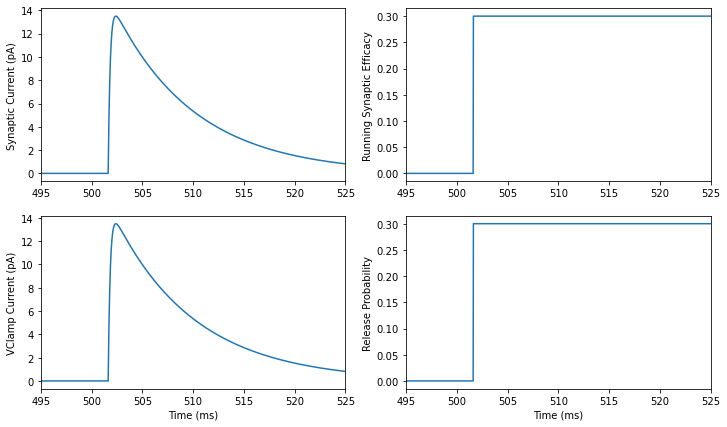

In [8]:
def plot_model(xlim=[]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))
    axs = axs.ravel()
    axs[0].plot(t, 1000 * isyn)
    axs[0].set_ylabel('Synaptic Current (pA)')
    ispk = int(np.round(tspk[0] / h.dt))
    if vcl_on:
        baseline = ivcl[ispk]
        ivcl_plt = np.array(ivcl) - baseline
        ivcl_plt[:ispk] = 0
        axs[2].plot(t, 1000 * ivcl_plt)
        axs[2].set_ylabel('VClamp Current (pA)')
    else:
        soma_v_plt = np.array(soma_v)
        soma_v_plt[:ispk] = soma_v_plt[ispk]
        axs[2].plot(t, soma_v_plt)
        axs[2].set_ylabel('Soma Voltage (mV)')
    axs[1].plot(t, Use_rec)
    axs[1].set_ylabel('Running Synaptic Efficacy')
    axs[3].plot(t, Pr)
    axs[3].set_ylabel('Release Probability')
    for i, ax in enumerate(axs):
        ax.set_xlim(*xlim)
        if i > 1:
            ax.set_xlabel('Time (ms)')
    plt.show()

plot_model([tstart - 5, tstart + 25])

### Short term plasticity

Paired Pulse Ratio using PSC: 1.251


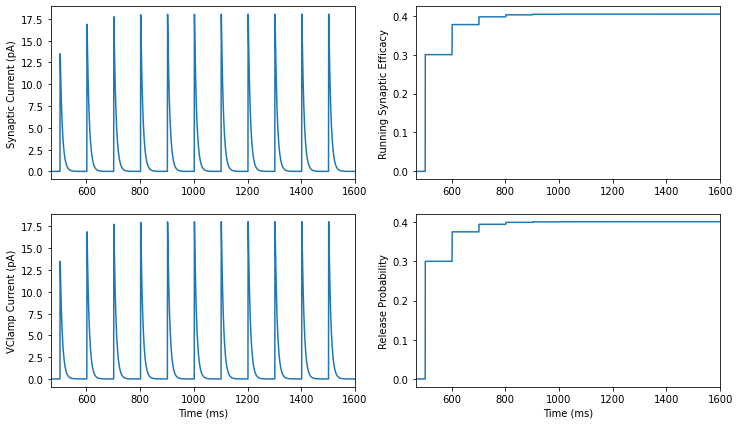

In [9]:
def simulate_model(weight, input_frequency, Use, tau_f, tau_d):
    nstim.interval = 1000 / input_frequency
    nstim.number = np.ceil(tdur / 1000 * input_frequency + 1)
    syn.initW = weight #synaptic weight for our synapse
    syn.Fac = tau_f
    syn.Dep = tau_d
    syn.Use = Use
    
    h.finitialize(cell.Vinit * mV)
    h.continuerun(tstop * ms)

w_run = widgets.Button(description='Run', icon='history', button_style='primary')
w_vclamp = widgets.ToggleButton(value=settings['vclamp'], description='Voltage Clamp', icon='check', button_style='primary')
w_weight = widgets.FloatSlider(value=syn_param['initW'], min=0., max=100., step=1e-3, description='Syn Weight')
w_input_freq = widgets.FloatSlider(value=40, min=1., max=100., step=0.1, description='Input Freq')
w_Use = widgets.FloatSlider(value=syn_param['Use'], min=0.,max=1., step=1e-3, description='Init Efficacy')
w_tau_f = widgets.FloatSlider(value=syn_param['Fac'], min=0, max=1000, step=1e-3, description='tau fac')
w_tau_d = widgets.FloatSlider(value=syn_param['Dep'], min=0, max=1000, step=1e-3, description='tau dep')

def update_ui(*arges):
    clear_output()
    display(ui)
    switch_vclamp(w_vclamp.value)
    simulate_model(w_weight.value, w_input_freq.value, w_Use.value, w_tau_f.value, w_tau_d.value)
    ppr = paired_pulse_ratio(isyn if vcl_on else soma_v, tspk)
    print('Paired Pulse Ratio using ' + ('PSC' if vcl_on else 'PSP') + f': {ppr:.3f}')
    plot_model([tstart - nstim.interval / 3, tstop])
    
w_run.on_click(update_ui) 

ui = VBox([HBox([w_run, w_vclamp]), w_weight, HBox([w_input_freq, w_Use]), HBox([w_tau_d, w_tau_f])])
update_ui()

### Fit PPR

In [10]:
def PPR(freq, Use, tau_d, tau_f):
    t = 1000. / freq # Hz to ms
    rd = np.exp(-t / tau_d)
    rf = np.exp(-t / tau_f)
    ppr = (1. + rf * (1. - Use)) * (1. - rd * Use)
    return ppr

def Fit_PPR(freq, ppr, weight=(1., 1., 1.), Use=None):

    sigma = 1. / np.array(weight)
    if Use is not None:
#         bounds = (0., np.inf)
        bounds = (-np.inf, np.log(1000.))
        popt, _ = curve_fit(lambda f, *args: np.log(PPR(f, Use, *np.exp(args))), freq, np.log(ppr),
                    p0=np.log((50., 50.)), bounds=bounds, sigma=sigma, maxfev=10000)
    else:
#         bounds = ((0., 0., 0.), (1., np.inf, np.inf))
        bounds = (-np.inf, (0., np.log(1000.), np.log(1000.)))
        popt, _ = curve_fit(lambda f, *args: np.log(PPR(f, *np.exp(args))), freq, np.log(ppr),
                            p0=np.log((0.5, 50., 50.)), bounds=bounds, sigma=sigma, maxfev=10000)
    popt = np.exp(popt)
    return popt

In [11]:
# ppr_data = np.array([(10, 2.0), (25, 2.5), (40, 2.3)]).T
# popt = Fit_PPR(ppr_data[0], ppr_data[1], Use=0.13) # , weight=(1., .1, 1.)
# np.set_printoptions(formatter={'float': '{: 0.4g}'.format})
# print(np.array(popt))